In [1]:
import pandas as pd
from utilities import read_companys_dataset, read_base_dataset

In [2]:
pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
base_df = read_base_dataset()
company_df = read_companys_dataset()

Number of Base Dataset Columns: 78
Number of Own Dataset Columns: 84
These are the fields in our own dataset that we need to drop :
 {'Protocol', 'Src Port', 'Flow ID', 'Timestamp', 'Src IP', 'Dst IP'} 

Number of fields within the company's dataset: 78


In [3]:
# Convert Labels to Binary Class
base_df['Label'] = base_df['Label'].apply(lambda x: 0 if 'BENIGN' in x else 1)

In [4]:
print("<< Base Dataset >>")
print("Original Size:", base_df.shape[0])
base_df.dropna(axis=0, inplace=True)
print("Reduced Size:", base_df.shape[0])


<< Base Dataset >>
Original Size: 225745
Reduced Size: 225711


In [5]:
# Random choice to reduce the size of the dataset
base_df = base_df.sample(frac=0.1, random_state=42)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(base_df.iloc[:,0:-1],base_df['Label'], test_size=0.3, random_state=42)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier(n_neighbors =5, algorithm = 'ball_tree', leaf_size=500))])

pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=500))])

In [8]:
# Test on VALIDATION set
pipe.score(X_test, y_test)

0.9988186650915535

In [9]:
y_predict = pipe.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
print("Recall is {}." .format(round(recall,4)))
print("F is {}.".format(round(f1_score(y_test,y_predict),4)))

Recall is 0.999.
F is 0.999.


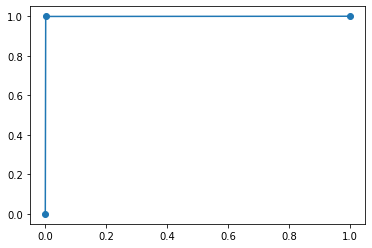

AUC is 0.999.


In [11]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=1)
plt.plot(fpr,tpr,marker = 'o')
plt.show()
from sklearn.metrics import auc
AUC = auc(fpr, tpr)
print ("AUC is {}.".format(round(recall,4)))

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, y_predict)

array([[2924,    4],
       [   4, 3840]])